In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import time
from IPython import display
import numpy.ma as ma
import seaborn as sns
from scipy.ndimage import morphology
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import sksurv
from metrics import cindex

# Images

In [177]:
archive = np.load('train/images/patient_002.npz')
scan = archive['scan']
mask = archive['mask']

### Visualization

In [178]:
# Shows the mask over each image of the scan to visualize the tumor

for i in range(scan.shape[2]):
            
    if np.isin(True, mask[:,:,i]):
        
        edges = mask[:,:,i] ^ morphology.binary_dilation(mask[:,:,i])
        plt.imshow(scan[:,:,i], cmap='gray')
        plt.imshow(edges, alpha=0.2, cmap='gray')
        
        plt.show()
        display.display(plt.gcf())
        display.clear_output(wait=True)
        time.sleep(0.05)        

<Figure size 432x288 with 0 Axes>

# Clinical Data

In [179]:
train_clinical = pd.read_csv('train/features/clinical_data.csv')
train_clinical.head()

,PatientID,Histology,Mstage,Nstage,SourceDataset,Tstage,age
0,202,Adenocarcinoma,0,0,l2,2,66.0000
1,371,large cell,0,2,l1,4,64.5722
2,246,squamous cell carcinoma,0,3,l1,2,66.0452
3,240,nos,0,2,l1,3,59.3566
4,284,squamous cell carcinoma,0,3,l1,4,71.0554


In [180]:
test_clinical = pd.read_csv('test/features/clinical_data.csv')
test_clinical.head()

,PatientID,Histology,Mstage,Nstage,SourceDataset,Tstage,age
0,13,nos,0,0,l1,4,44.3970
1,155,adenocarcinoma,0,3,l1,1,63.3183
2,404,large cell,0,2,l1,2,64.7255
3,407,nos,0,0,l1,2,65.3635
4,9,Adenocarcinoma,0,0,l2,2,50.0000


In [181]:
train_clinical.isna().sum()

PatientID         0
Histology        20
Mstage            0
Nstage            0
SourceDataset     0
Tstage            0
age              16
dtype: int64

Looks like there are a few NaN values.

In [182]:
train_clinical['Histology'].value_counts()

Adenocarcinoma                         80
large cell                             61
squamous cell carcinoma                59
nos                                    38
adenocarcinoma                         21
Squamous cell carcinoma                19
NSCLC NOS (not otherwise specified)     2
Name: Histology, dtype: int64

We can see there is twice the `Adenocarcinoma` label, one starting with `A`, the other with `a`. Same with `S` from `Squamous`.   
`NSCLC NOS` and `nos` seem to be the same thing.
Let's replace all NaNs with 'nos', and correct spelling mistakes.

In [183]:
train_clinical = train_clinical.fillna({'Histology':'nos'})
train_clinical.loc[train_clinical['Histology'].str.startswith('Adeno'), 'Histology'] = 'adenocarcinoma'
train_clinical.loc[train_clinical['Histology'].str.startswith('Squamous'), 'Histology'] = 'squamous cell carcinoma'
train_clinical.loc[train_clinical['Histology'].str.startswith('NSCLC'), 'Histology'] = 'nos'

In [184]:
train_clinical['Histology'].value_counts()

adenocarcinoma             101
squamous cell carcinoma     78
large cell                  61
nos                         60
Name: Histology, dtype: int64

In [185]:
train_clinical = train_clinical.dropna()
train_clinical.head()

,PatientID,Histology,Mstage,Nstage,SourceDataset,Tstage,age
0,202,adenocarcinoma,0,0,l2,2,66.0000
1,371,large cell,0,2,l1,4,64.5722
2,246,squamous cell carcinoma,0,3,l1,2,66.0452
3,240,nos,0,2,l1,3,59.3566
4,284,squamous cell carcinoma,0,3,l1,4,71.0554


Let's take a quick look at the dataset distribution

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f04cfbe6550>],
      dtype=object)

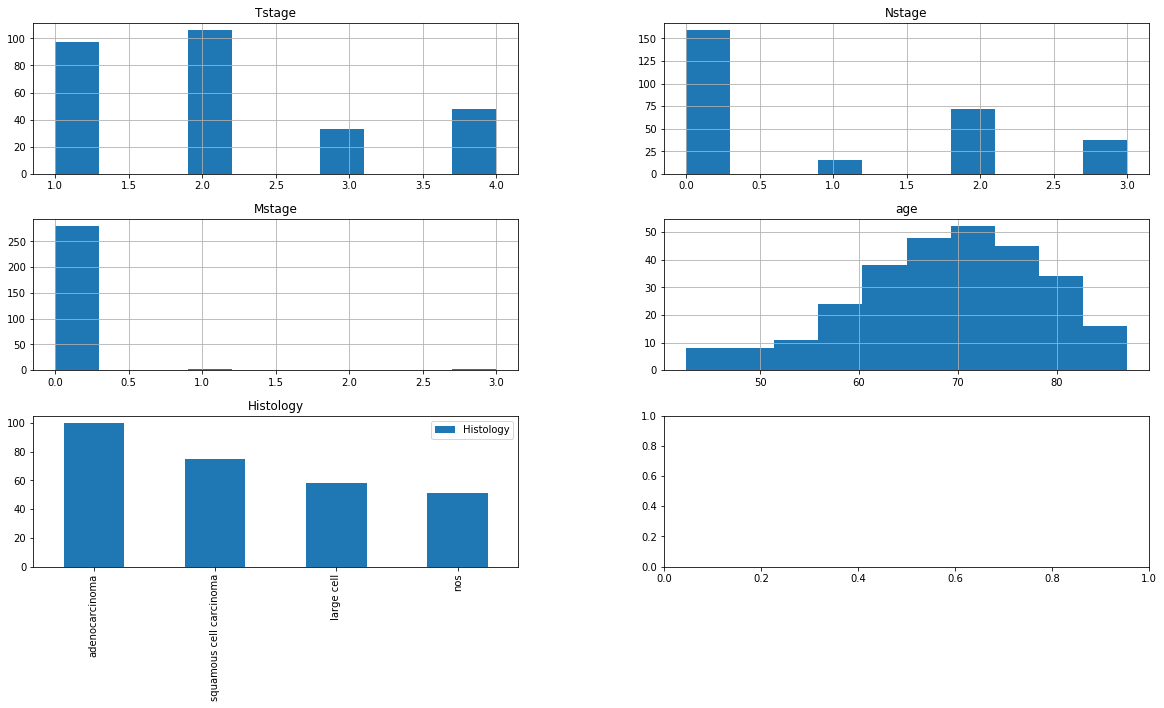

In [186]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 10))
train_clinical[['Tstage']].hist(ax=axes[0,0])
train_clinical[['Nstage']].hist(ax=axes[0,1])
train_clinical[['Mstage']].hist(ax=axes[1,0])
train_clinical[['age']].hist(ax=axes[1,1])
train_clinical[['Histology']].apply(pd.value_counts).plot(kind='bar', subplots=True, ax=axes[2,0])

# Radiomics

In [187]:
train_radiomics = pd.read_csv('train/features/radiomics.csv', index_col=0, header=1)[1:]
test_radiomics = pd.read_csv('test/features/radiomics.csv', index_col=0, header=1)[1:]

print(train_radiomics.shape)
train_radiomics.head()

(300, 53)


,original_shape_Compactness1,original_shape_Compactness2,original_shape_Maximum3DDiameter,original_shape_SphericalDisproportion,original_shape_Sphericity,original_shape_SurfaceArea,original_shape_SurfaceVolumeRatio,original_shape_VoxelVolume,original_firstorder_Energy,original_firstorder_Entropy,...,original_glrlm_LongRunEmphasis,original_glrlm_GrayLevelNonUniformity,original_glrlm_RunLengthNonUniformity,original_glrlm_RunPercentage,original_glrlm_LowGrayLevelRunEmphasis,original_glrlm_HighGrayLevelRunEmphasis,original_glrlm_ShortRunLowGrayLevelEmphasis,original_glrlm_ShortRunHighGrayLevelEmphasis,original_glrlm_LongRunLowGrayLevelEmphasis,original_glrlm_LongRunHighGrayLevelEmphasis
202,0.027815,0.274892,48.559242,1.537964,0.650210,5431.333210,0.275228,19786.0,3.942944e+09,5.138062,...,1.457980,555.378594,14592.303727,0.891330,0.003562,954.749135,0.003384,851.987373,0.004444,1651.710761
371,0.023015,0.188210,75.703368,1.744961,0.573079,10369.568729,0.240727,43168.0,3.122890e+09,4.461054,...,2.512125,1766.619373,22881.932686,0.766032,0.002246,1092.823724,0.002069,884.838627,0.003633,3386.995589
246,0.027348,0.265740,70.434367,1.555420,0.642913,10558.818691,0.200766,52655.0,1.059535e+09,3.437111,...,4.096838,3462.816344,18773.106002,0.644554,0.001880,878.989601,0.001635,634.910036,0.004869,4232.418080
240,0.026811,0.255406,46.818800,1.576120,0.634469,4221.412123,0.323878,13074.0,6.583324e+08,4.352564,...,1.824328,683.869792,7978.285176,0.828138,0.002855,907.045929,0.002680,774.885387,0.003901,1844.746046
284,0.023691,0.199424,53.795911,1.711620,0.584242,5295.900331,0.327241,16237.0,8.072532e+08,4.055700,...,2.652580,962.094760,7520.054910,0.734898,0.006710,1513.420445,0.004704,1197.140900,0.023273,4444.272812


In [188]:
train_radiomics.describe()

,original_shape_Compactness1,original_shape_Compactness2,original_shape_Maximum3DDiameter,original_shape_SphericalDisproportion,original_shape_Sphericity,original_shape_SurfaceArea,original_shape_SurfaceVolumeRatio,original_shape_VoxelVolume,original_firstorder_Energy,original_firstorder_Entropy,...,original_glrlm_LongRunEmphasis,original_glrlm_GrayLevelNonUniformity,original_glrlm_RunLengthNonUniformity,original_glrlm_RunPercentage,original_glrlm_LowGrayLevelRunEmphasis,original_glrlm_HighGrayLevelRunEmphasis,original_glrlm_ShortRunLowGrayLevelEmphasis,original_glrlm_ShortRunHighGrayLevelEmphasis,original_glrlm_LongRunLowGrayLevelEmphasis,original_glrlm_LongRunHighGrayLevelEmphasis
count,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,3.000000e+02,300.000000,...,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000
mean,0.026078,0.255309,63.735090,1.666887,0.618682,10269.274116,0.332531,55941.000000,2.725407e+09,4.232072,...,2.997984,4028.912972,21708.293730,0.770259,0.004949,1053.341229,0.004411,842.425719,0.009939,3956.614366
std,0.006213,0.114462,35.533323,0.321580,0.101082,11020.943961,0.165777,82370.656898,5.094067e+09,0.895564,...,2.277218,7354.203503,30741.811717,0.139863,0.008117,367.251140,0.006535,257.999681,0.025015,3721.271813
min,0.009288,0.030648,13.453624,1.154634,0.312946,409.699505,0.092706,640.000000,2.388461e+07,2.178197,...,1.129743,20.662759,503.361305,0.420690,0.000636,259.345076,0.000401,245.062735,0.001749,325.511805
25%,0.022028,0.172413,33.915016,1.443163,0.556575,2187.199167,0.200968,5586.750000,5.434917e+08,3.539630,...,1.380404,179.737494,3594.097996,0.653939,0.001541,790.854216,0.001333,657.397218,0.003539,1396.425566
50%,0.026071,0.241503,57.823002,1.605803,0.622741,5669.467145,0.296289,19523.000000,1.093244e+09,4.372496,...,2.183706,891.648859,10812.628268,0.793196,0.002709,1048.240239,0.002490,850.097187,0.004787,2566.288530
75%,0.030600,0.332701,82.933158,1.796703,0.692923,14084.942660,0.426285,68332.250000,2.994063e+09,5.017558,...,3.928845,4138.067422,28318.086695,0.903259,0.005065,1323.465451,0.004650,1017.454004,0.007573,5583.538887
max,0.042759,0.649631,216.716405,3.195442,0.866075,67799.783468,0.828710,502660.000000,5.101016e+10,5.585623,...,19.569205,61727.567864,267812.272378,0.960043,0.095065,1960.134253,0.069937,1621.293515,0.282310,25570.594397


In [189]:
test_radiomics.describe()

,original_shape_Compactness1,original_shape_Compactness2,original_shape_Maximum3DDiameter,original_shape_SphericalDisproportion,original_shape_Sphericity,original_shape_SurfaceArea,original_shape_SurfaceVolumeRatio,original_shape_VoxelVolume,original_firstorder_Energy,original_firstorder_Entropy,...,original_glrlm_LongRunEmphasis,original_glrlm_GrayLevelNonUniformity,original_glrlm_RunLengthNonUniformity,original_glrlm_RunPercentage,original_glrlm_LowGrayLevelRunEmphasis,original_glrlm_HighGrayLevelRunEmphasis,original_glrlm_ShortRunLowGrayLevelEmphasis,original_glrlm_ShortRunHighGrayLevelEmphasis,original_glrlm_LongRunLowGrayLevelEmphasis,original_glrlm_LongRunHighGrayLevelEmphasis
count,125.000000,125.000000,125.000000,125.000000,125.000000,125.000000,125.000000,125.000000,1.250000e+02,125.000000,...,125.000000,125.000000,125.000000,125.000000,125.000000,125.000000,125.000000,125.000000,125.000000,125.000000
mean,0.025118,0.236966,69.005235,1.703977,0.603505,11108.986749,0.329683,64448.800000,2.907749e+09,4.226877,...,2.907961,4862.013570,23698.859346,0.771691,0.004914,1067.592547,0.004454,850.227158,0.008829,3965.904113
std,0.006026,0.109468,35.036927,0.297328,0.097993,11153.620894,0.162203,98583.891199,4.855596e+09,0.879179,...,1.909055,9508.793837,28046.899035,0.137845,0.005647,410.333975,0.005167,286.107130,0.011422,3573.480389
min,0.013143,0.061374,13.076697,1.209814,0.394452,360.071913,0.072954,452.000000,1.259652e+07,2.050655,...,1.150945,17.308783,381.924525,0.470120,0.000589,204.978378,0.000372,187.542820,0.001236,260.520715
25%,0.021155,0.159013,39.673669,1.483791,0.541764,2761.980187,0.195032,6477.000000,5.793611e+08,3.562918,...,1.429070,199.514478,4131.239836,0.664557,0.001285,789.065354,0.001127,670.422407,0.003477,1302.787017
50%,0.025103,0.223893,61.465437,1.646847,0.607221,6903.189417,0.293765,23837.000000,1.305141e+09,4.366508,...,2.047726,1004.947137,13212.132338,0.803295,0.002856,1057.545637,0.002387,860.576758,0.004642,2588.351267
75%,0.029352,0.306113,94.085068,1.845821,0.673949,15654.530686,0.434650,71020.000000,3.188115e+09,4.951592,...,3.625308,4324.460947,33593.524578,0.896831,0.006365,1414.067667,0.005432,1064.304574,0.008266,5844.246813
max,0.039868,0.564735,169.493363,2.535161,0.826574,48379.431837,0.815950,663274.000000,4.150966e+10,5.642572,...,9.140457,63017.077002,149668.340098,0.955711,0.031884,1845.339082,0.029628,1582.554219,0.077180,17109.336509


In [190]:
normalized_df = (train_radiomics-train_radiomics.min())/(train_radiomics.max()-train_radiomics.min())
normalized_df.describe()

,original_shape_Compactness1,original_shape_Compactness2,original_shape_Maximum3DDiameter,original_shape_SphericalDisproportion,original_shape_Sphericity,original_shape_SurfaceArea,original_shape_SurfaceVolumeRatio,original_shape_VoxelVolume,original_firstorder_Energy,original_firstorder_Entropy,...,original_glrlm_LongRunEmphasis,original_glrlm_GrayLevelNonUniformity,original_glrlm_RunLengthNonUniformity,original_glrlm_RunPercentage,original_glrlm_LowGrayLevelRunEmphasis,original_glrlm_HighGrayLevelRunEmphasis,original_glrlm_ShortRunLowGrayLevelEmphasis,original_glrlm_ShortRunHighGrayLevelEmphasis,original_glrlm_LongRunLowGrayLevelEmphasis,original_glrlm_LongRunHighGrayLevelEmphasis
count,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,...,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000
mean,0.501642,0.362951,0.247372,0.251005,0.552740,0.146306,0.325848,0.110157,0.052985,0.602764,...,0.101318,0.064956,0.079327,0.648127,0.045672,0.466840,0.057673,0.434057,0.029195,0.143834
std,0.185619,0.184920,0.174815,0.157575,0.182746,0.163540,0.225239,0.164078,0.099911,0.262827,...,0.123497,0.119180,0.115005,0.259317,0.085957,0.215930,0.093983,0.187468,0.089160,0.147406
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.380645,0.229029,0.100665,0.141379,0.440456,0.026376,0.147095,0.009854,0.010191,0.399549,...,0.013594,0.002578,0.011562,0.432462,0.009580,0.312507,0.013401,0.299611,0.006383,0.042421
50%,0.501424,0.340648,0.218286,0.221074,0.560078,0.078050,0.276606,0.037614,0.020973,0.643976,...,0.057158,0.014115,0.038567,0.690655,0.021953,0.463841,0.030051,0.439632,0.010831,0.088761
75%,0.636736,0.487983,0.341821,0.314615,0.686958,0.202927,0.453231,0.134840,0.058254,0.833286,...,0.151800,0.066725,0.104055,0.894718,0.046899,0.625663,0.061113,0.561237,0.020760,0.208279
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


/home/david/.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3291: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  exec(code_obj, self.user_global_ns, self.user_ns)


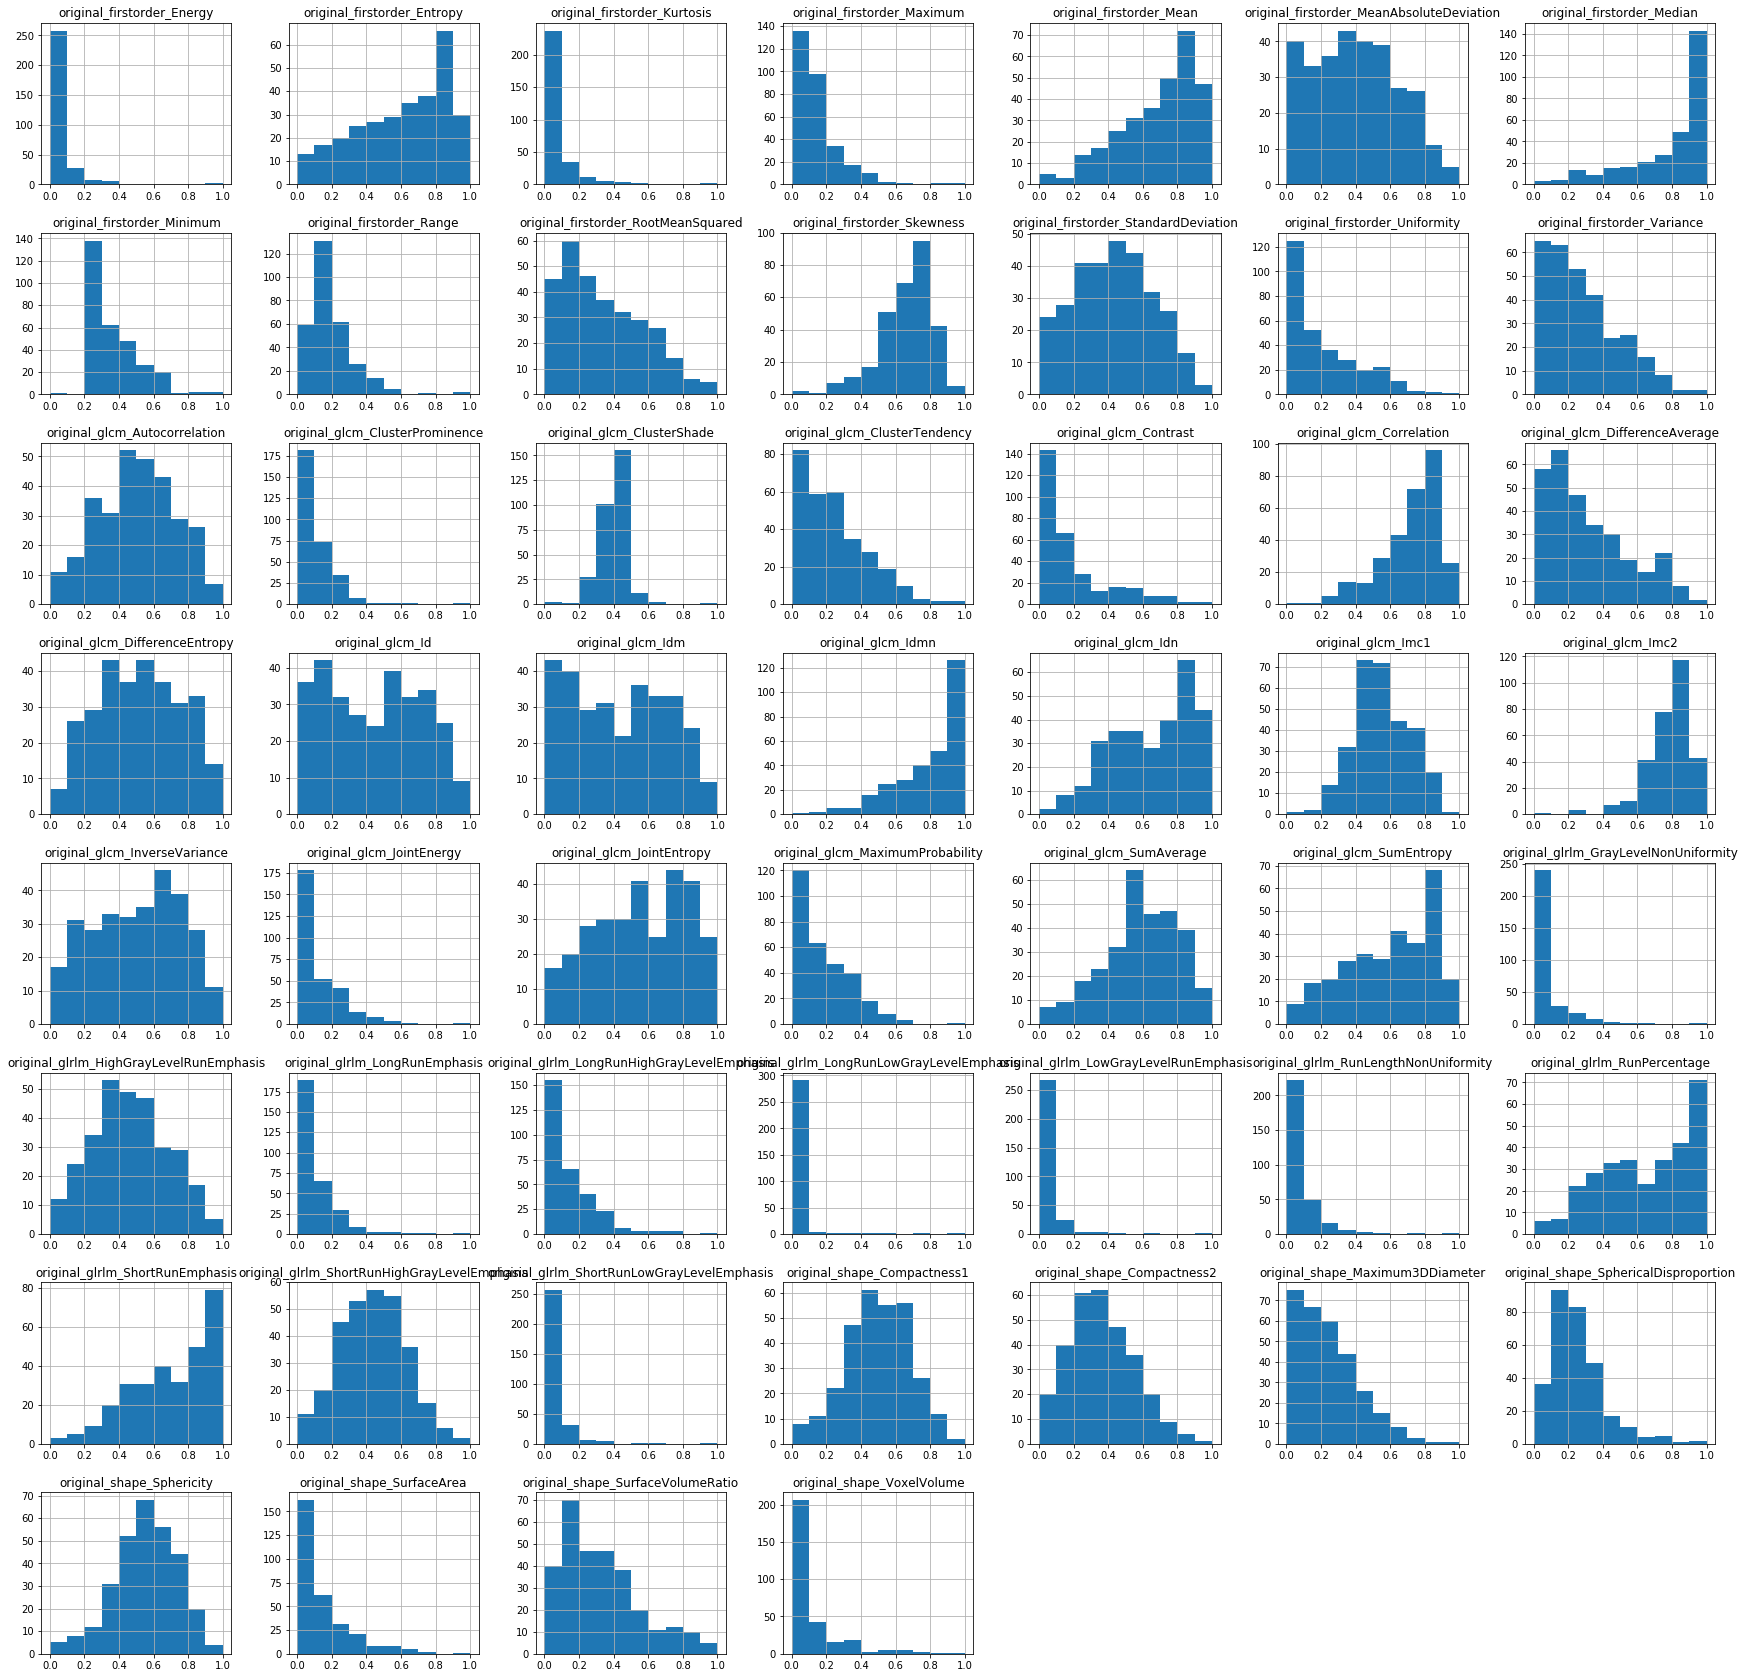

In [191]:
fig = plt.figure(figsize = (30,30))
ax = fig.gca()
normalized_df.hist(ax = ax)
plt.show()

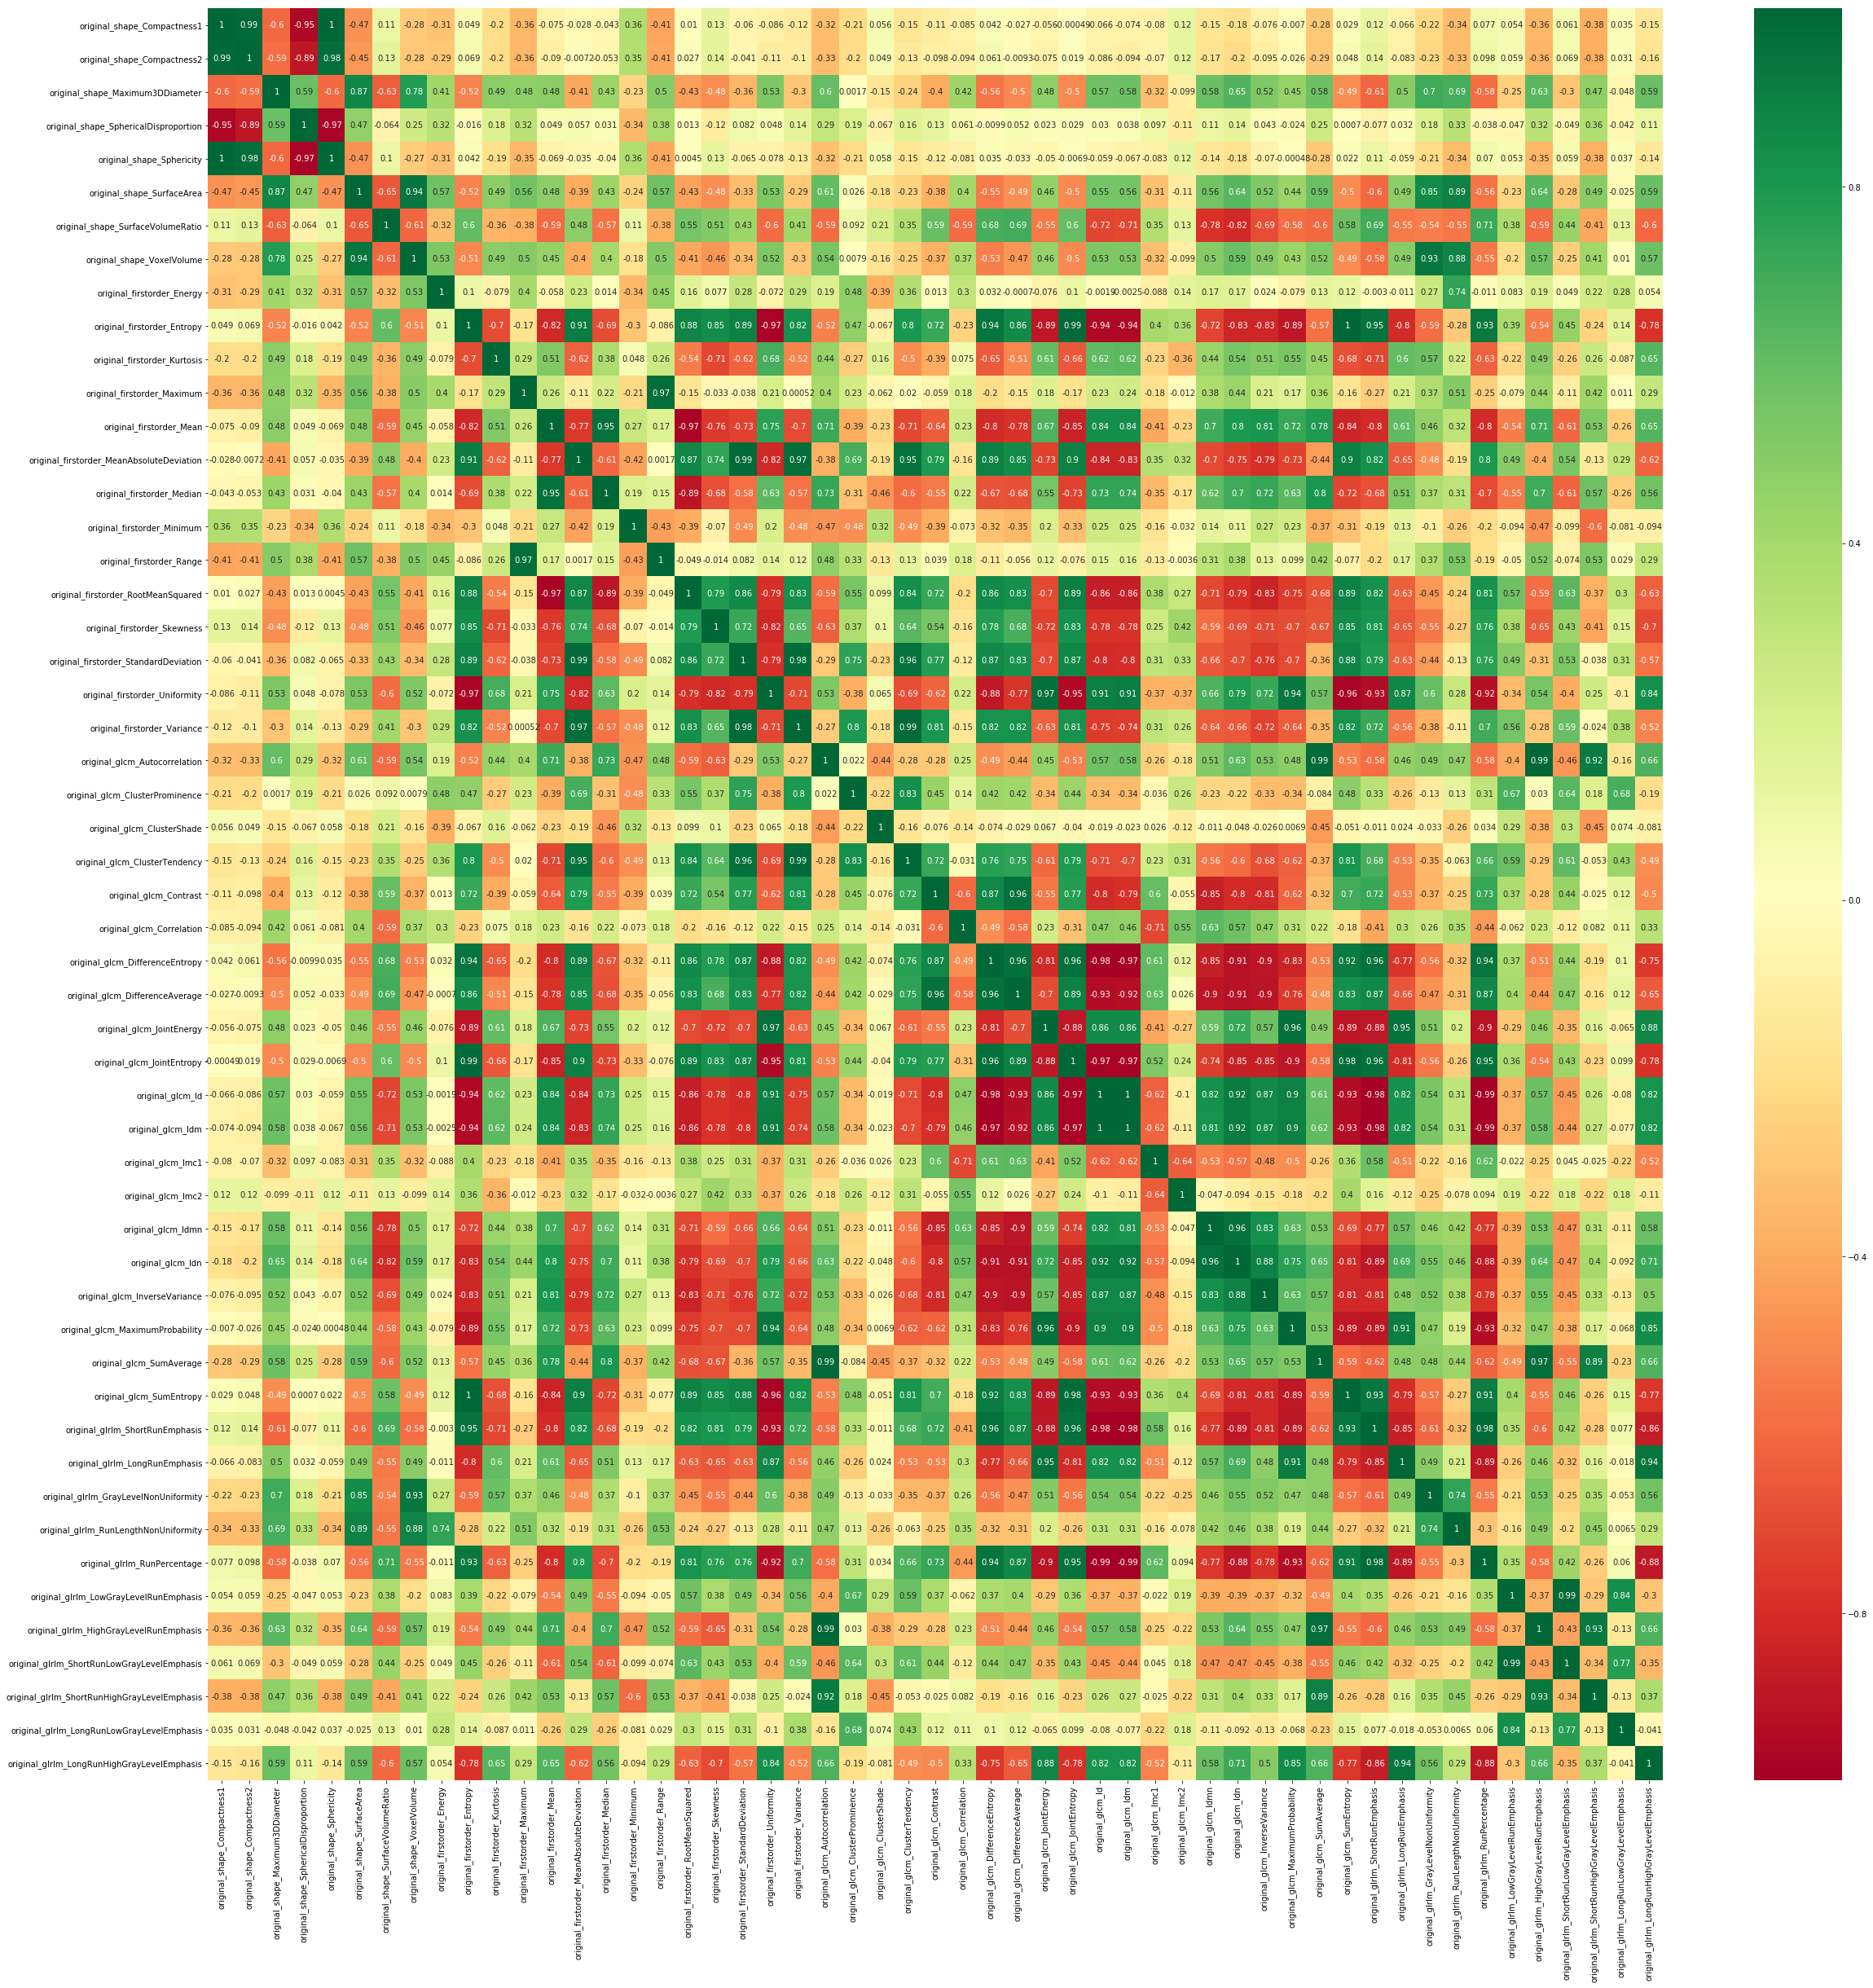

In [192]:
corrmat = normalized_df.corr()
top_corr_features = corrmat.index
plt.figure(figsize =(40,40))
#plot heat map
g=sns.heatmap(normalized_df[top_corr_features].corr(),annot=True,cmap="RdYlGn")

We have quite some features that are very correlated.  
This tells us we'll probably have to do some feature engineering/feature selection

# Output

In [195]:
train_output = pd.read_csv('output.csv', index_col=0)
train_output.head()

,SurvivalTime,Event
PatientID,,
202,1378,0
371,379,1
246,573,1
240,959,0
284,2119,0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f04d80e4a20>,
      dtype=object)

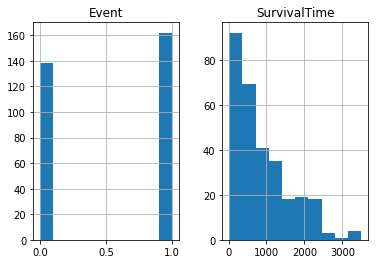

In [196]:
train_output.hist()

# Reproduce Baseline Model

In [5]:
train_clinical = pd.read_csv('train/features/clinical_data.csv')
train_radiomics = pd.read_csv('train/features/radiomics.csv', index_col=0, header=1)[1:]

scaler = MinMaxScaler()
index = train_radiomics.index.astype(int)
train_radiomics = pd.DataFrame(columns=train_radiomics.columns, data=scaler.fit_transform(train_radiomics))
train_radiomics.set_index(index, inplace=True)
train_radiomics.sort_index(inplace=True)

train_clinical = train_clinical.set_index('PatientID').sort_index()
train_clinical.sort_index(inplace=True)
le = LabelEncoder()
train_clinical['SourceDataset'] = le.fit_transform(train_clinical['SourceDataset'])

train_output = pd.read_csv('output.csv', index_col=0)
train_output.sort_index(inplace=True)

In [9]:
columns = [
           'original_shape_Sphericity',
           'original_shape_SurfaceVolumeRatio',
           'original_shape_Maximum3DDiameter', 
           'SourceDataset', 
           'Nstage',
           'original_glcm_JointEntropy', 
           'original_glcm_Id', 
           'original_glcm_Idm',
]

X = pd.concat([train_radiomics, train_clinical], axis=1)[columns]

y = sksurv.util.Surv.from_dataframe('Event', 'SurvivalTime', train_output)

In [10]:
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.linear_model import CoxnetSurvivalAnalysis
from sksurv.ensemble import GradientBoostingSurvivalAnalysis

model = CoxPHSurvivalAnalysis()

model.fit(X, y)
print('c-index:', model.score(X,y))

c-index: 0.7021256405390017


In [11]:
survival_functions = model.predict_survival_function(X)

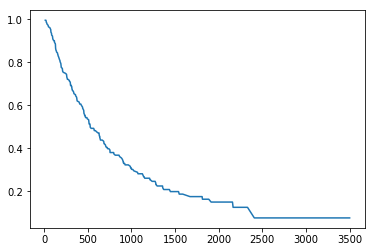

In [12]:
plt.plot(survival_functions[0].x, survival_functions[0].y)

This function gives us the patient's probability of being alive after a certain time (in days), but we want a prediction about the absolute survival time.  
We can use the median survival time for each patient.

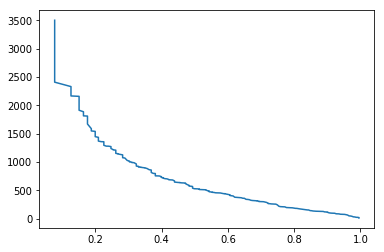

In [13]:
plt.plot(np.flip(survival_functions[0].y), np.flip(survival_functions[0].x))

In [14]:
survival_functions = model.predict_survival_function(X)

survival_times = []

for pred, label in zip(survival_functions, y):
    time_by_prob = sksurv.functions.StepFunction(np.flip(pred.y), np.flip(pred.x))
    try:
        time = time_by_prob(0.5)
    except:
        time = time_by_prob(pred.y[-1])
    
    survival_times.append(time)

In [16]:
preds = pd.DataFrame({'SurvivalTime': survival_times, 'Event': np.nan}).set_index(X.index)
print('c-index:', cindex(train_output, preds))

c-index: 0.7012307010881103


It looks like taking the median survival time gives us a good result.